In [20]:
import pandas 
from scipy.optimize import curve_fit
from scipy.stats import linregress
import numpy as np 

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt 
from matplotlib import rc

rc('font', family='Source Sans Pro') 
plt.style.use( 'bmh' ) 

In [22]:
master = pandas.read_csv( '../master_sheet.csv', index_col=0 )
master.head()

,sequence_pos,expression,tm,k,err_tm,err_k,kcat,err_kcat,km,err_km,kcatkm,err_kcatkm,ki,ki_percent_err,ki_err,gel_number
mutant,,,,,,,,,,,,,,,,
G12N,12.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
S14A,14.0,1,40.16,-1.72,0.30,0.37,320.0,11.0,8.25,1.02,38823,4972.0,NaN,NaN,NaN,9.0
T15A,15.0,1,39.17,-0.58,0.23,0.07,614.0,14.7,5.30,0.48,115849,1.7,NaN,NaN,NaN,2.0
S16A,16.0,1,39.41,-0.83,0.27,0.16,154.0,1.0,14.01,0.40,10997,331.0,NaN,NaN,NaN,5.0
S16N,16.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0


# BglB kinetic data and thermal stability data statistical analysis 

## Kinetics 

In [23]:
# see notebook in raw_for_pub for data preprocessing 
df = pandas.read_csv( 'pub/kinetics.csv' ) 
df = df[ ( df.kobs > 0 ) ] 

print( len( df.mutant.unique() ), 'unique names' ) 
print( df.columns ) 

11 unique names
Index(['Unnamed: 0', 'well', 'rate', 'mutant', 'protein_yield', 'dilution',
       'note', 'kobs', 's'],
      dtype='object')


In [24]:
def my_curve_fit( f, xdata, ydata, p0 ):
    null_return = ( [ np.nan, np.nan ], [ np.nan, np.nan ] )
    try:
        curve_return = curve_fit( f, xdata, ydata, p0 )
        if len( curve_return ) == 2:
            errors = np.sqrt( np.diag( curve_return[1] ) ) 
            return curve_return[0], errors 
        else:
            return null_return
    except:
        return null_return

In [25]:
def v( s, kcat, km ):
    return ( kcat * s ) / ( km + s )

In [26]:
for idx, data in df.groupby( 'mutant' ):
    if len( data ) != 24:
        print( idx, 'ain\'t got no ({} data points)'.format( len( data ) ) )

F415N ain't got no (21 data points)
L362M ain't got no (21 data points)
N220G ain't got no (21 data points)
N220R ain't got no (21 data points)
N220Y ain't got no (21 data points)
N293C ain't got no (21 data points)
N404C ain't got no (22 data points)
T15A ain't got no (21 data points)
W399R ain't got no (20 data points)
W409Y ain't got no (23 data points)
WT ain't got no (21 data points)


In [27]:
my_mutants = pandas.DataFrame( columns=[ 'kcat', 'km', 'err_kcat', 'err_km' ] ) 
for idx, data in df.groupby( 'mutant' ):
    params, std_err = my_curve_fit( v, data.s, data.kobs, ( data.kobs.max(), .1 ) )
    my_mutants.loc[ idx ] = np.append( params, std_err )
    
# rename my_mutants to mm_fits!!!!!!!!!!!

In [29]:
good_fits = pandas.DataFrame( columns=[ 'kcat', 'km', 'err_kcat', 'err_km' ] )
for idx, data in my_mutants.iterrows():
    if data.kcat > data.err_kcat and data.km > data.err_km:
        good_fits.loc[ idx ] = data 
    else:
        good_fits.loc[ idx ] = ( np.nan, np.nan, np.nan, np.nan )
        
good_fits

,kcat,km,err_kcat,err_km
F415N,0.893262,0.023069,0.028304,0.001944
L362M,918.087343,0.005201,9.788307,0.000212
N220G,210.359993,0.033505,6.201594,0.002337
N220R,14.914215,0.012419,0.528695,0.001389
N220Y,628.540551,0.000359,4.773314,0.000015
N293C,11.067364,0.019674,0.412238,0.002042
N404C,85.426232,0.014310,3.736344,0.001904
T15A,614.809247,0.005250,14.702099,0.000478
W399R,0.200114,0.003289,0.012749,0.000869
W409Y,810.751634,0.002553,13.267589,0.000180


In [30]:
master.columns

Index(['sequence_pos', 'expression', 'tm', 'k', 'err_tm', 'err_k', 'kcat',
       'err_kcat', 'km', 'err_km', 'kcatkm', 'err_kcatkm', 'ki',
       'ki_percent_err', 'ki_err', 'gel_number'],
      dtype='object')

In [32]:
for index, fit_params in good_fits.iterrows():
    
    if index in master.index:
        print( 'mutant {}'.format( index ) ) 
        master_fit_params = master.loc[ index ][ good_fits.columns ] 
        print( master_fit_params - fit_params ) 
    else:
        print( '{} not on master clipboard'.format( index ) ) 

mutant F415N
kcat        NaN
km          NaN
err_kcat    NaN
err_km      NaN
Name: F415N, dtype: object
mutant L362M
kcat        -1.08734
km            5.1948
err_kcat   -0.588307
err_km      0.189788
Name: L362M, dtype: object
mutant N220G
kcat         -1.35999
km            33.2665
err_kcat    0.0984057
err_km        2.35766
Name: N220G, dtype: object
mutant N220R
kcat         0.085785
km            12.4876
err_kcat   -0.0286949
err_km        1.38861
Name: N220R, dtype: object
mutant N220Y
kcat       -0.540551
km          0.399641
err_kcat     1.52669
err_km      0.019985
Name: N220Y, dtype: object
mutant N293C
kcat       -0.0673636
km            19.7803
err_kcat   -0.0122378
err_km        2.07796
Name: N293C, dtype: object
mutant N404C
kcat        -0.426232
km            14.3857
err_kcat   -0.0363443
err_km         1.8981
Name: N404C, dtype: object
mutant T15A
kcat         -0.809247
km             5.29475
err_kcat   -0.00209851
err_km        0.479522
Name: T15A, dtype: object
mutant

In [33]:
# try linear fits as well! 

lin_fits = pandas.DataFrame( columns=[ 'lin_slope', 'lin_intercept', 'rvalue', 'pvalue', 'lin_std_err' ] ) 
for idx, data in df.groupby( 'mutant' ):
    lin_fit = linregress( data.s, data.kobs ) 
    lin_fits.loc[ idx ] = lin_fit
    
lin_fits

,lin_slope,lin_intercept,rvalue,pvalue,lin_std_err
F415N,8.799014,0.068810,0.953245,2.518561e-11,0.639949
L362M,10582.450544,173.376352,0.832728,2.815468e-06,1614.234245
N220G,1928.091237,8.709798,0.960460,5.271270e-12,128.224128
N220R,164.234071,1.628680,0.894660,4.480779e-08,18.814422
N220Y,5104.036991,315.326278,0.558482,8.504364e-03,1739.215240
N293C,114.183613,0.857690,0.934192,6.009417e-10,10.004137
N404C,936.611795,8.633934,0.929241,4.231498e-10,83.272413
T15A,7092.101600,117.984849,0.840750,1.824634e-06,1047.777738
W399R,2.161353,0.054813,0.775024,5.991466e-05,0.415379
W409Y,9261.407013,193.806561,0.749105,3.904629e-05,1787.220209


In [34]:
any( np.array( [ np.nan, np.nan, np.nan, ] ) )

True

All the plotting logic goes here, to produce publication-quality plots is a lot of code

In [35]:
def lin_f( x, m, b ):
    return m*x+b

F415N 
 MM params (kcat, km): [ 0.89326191  0.02306939] 
 linear params (slope, int): [ 8.79901415  0.06880959]


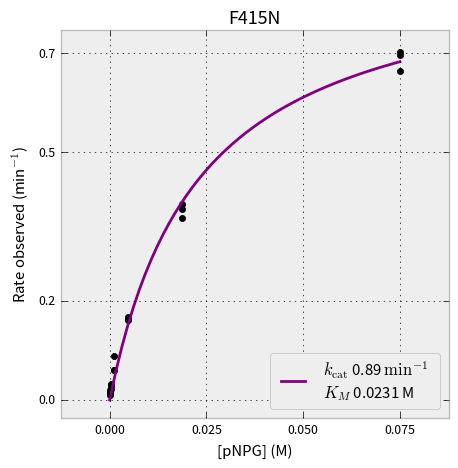

L362M 
 MM params (kcat, km): [  9.18087343e+02   5.20084339e-03] 
 linear params (slope, int): [ 10582.45054403    173.37635194]


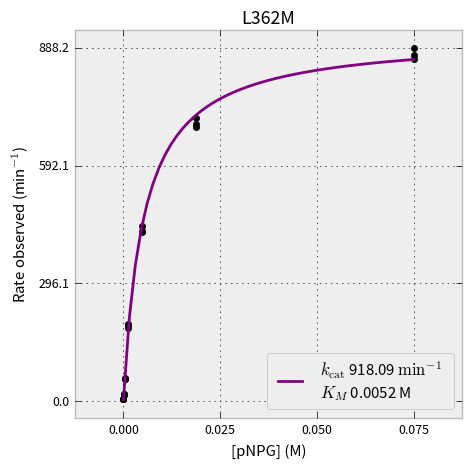

N220G 
 MM params (kcat, km): [  2.10359993e+02   3.35046900e-02] 
 linear params (slope, int): [ 1928.09123694     8.70979841]


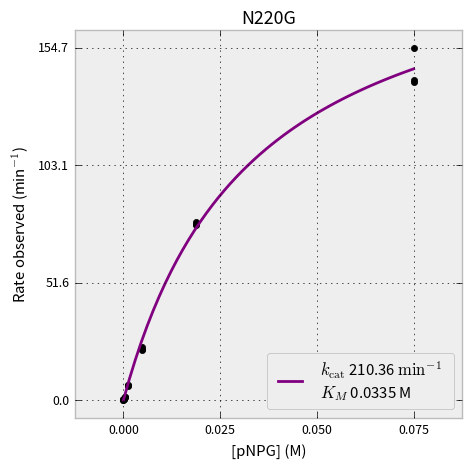

N220R 
 MM params (kcat, km): [  1.49142150e+01   1.24194785e-02] 
 linear params (slope, int): [ 164.2340711     1.62868022]


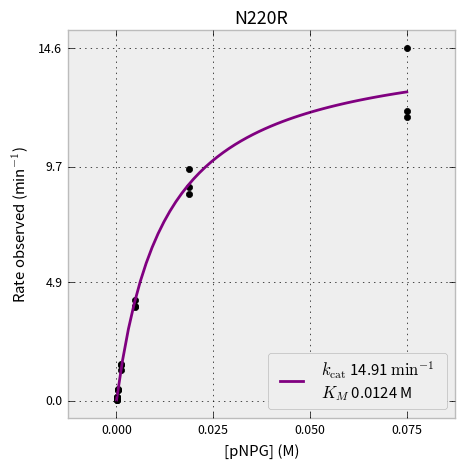

N220Y 
 MM params (kcat, km): [  6.28540551e+02   3.59310132e-04] 
 linear params (slope, int): [ 5104.0369906    315.32627803]


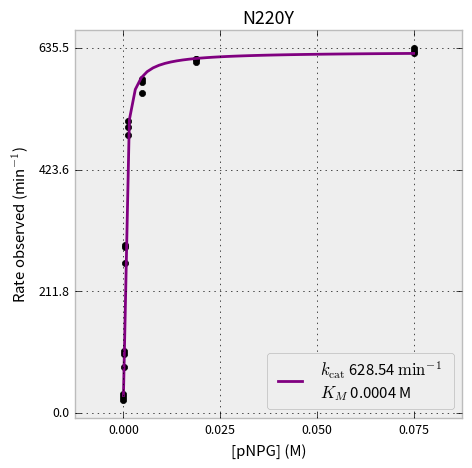

N293C 
 MM params (kcat, km): [ 11.06736362   0.01967436] 
 linear params (slope, int): [ 114.18361308    0.85768976]


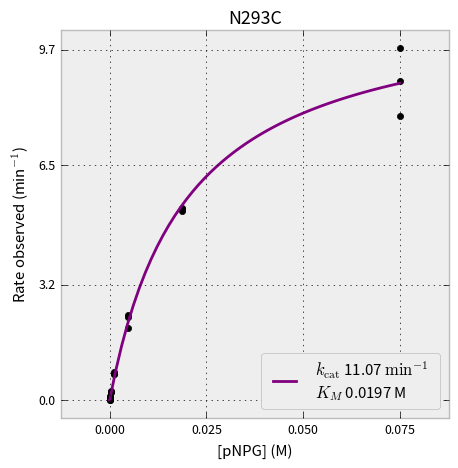

N404C 
 MM params (kcat, km): [  8.54262316e+01   1.43103644e-02] 
 linear params (slope, int): [ 936.61179489    8.63393393]


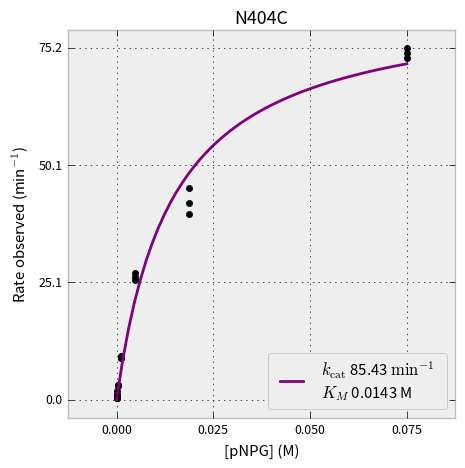

T15A 
 MM params (kcat, km): [  6.14809247e+02   5.24978722e-03] 
 linear params (slope, int): [ 7092.10159966   117.98484897]


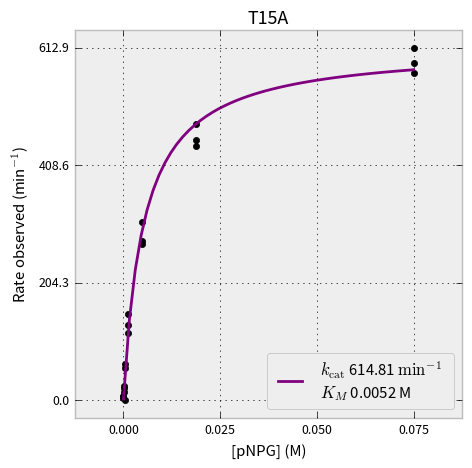

W399R 
 MM params (kcat, km): [ 0.20011444  0.00328934] 
 linear params (slope, int): [ 2.16135273  0.05481296]


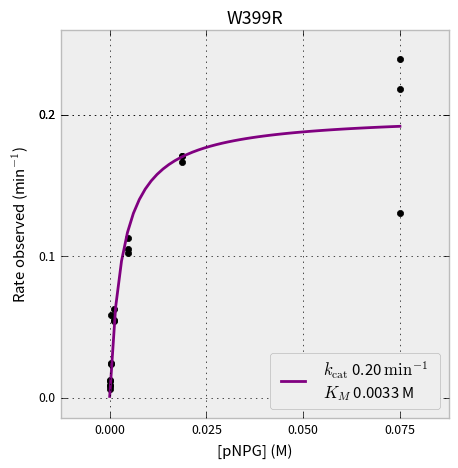

W409Y 
 MM params (kcat, km): [  8.10751634e+02   2.55297253e-03] 
 linear params (slope, int): [ 9261.40701302   193.80656077]


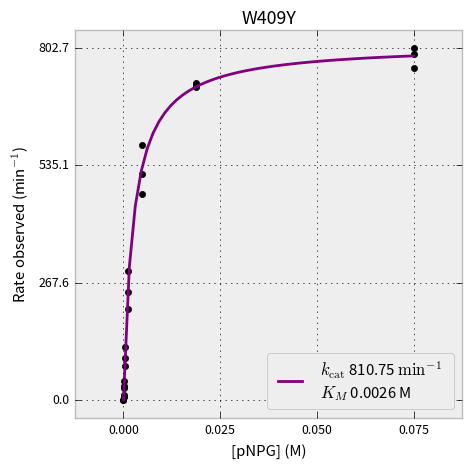

WT 
 MM params (kcat, km): [  9.19667384e+02   5.21800183e-03] 
 linear params (slope, int): [ 10601.56820288    169.85314971]


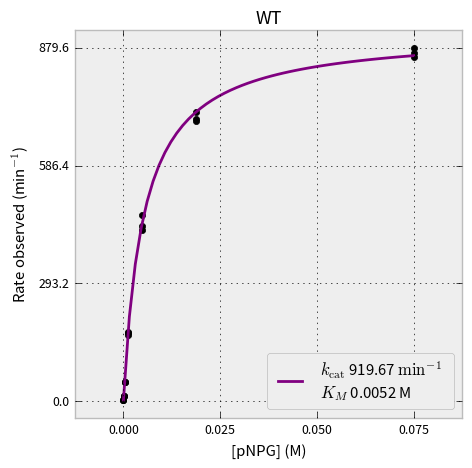

In [36]:
for i, (idx, data) in enumerate( df.groupby( 'mutant' ) ):
    
    x_vals = np.linspace( data.s.min(), data.s.max(), 50 )
    my_params = good_fits.loc[ idx ][ 0 : 2 ] # could be [ [ 'kcat', 'km' ] ] 
    my_lin = lin_fits.loc[ idx ][ [ 'lin_slope', 'lin_intercept' ] ]
    print( idx, '\n MM params (kcat, km):', my_params.values, '\n linear params (slope, int):', my_lin.values ) 

    plt.figure( figsize=( 5, 5 ) ) 
    plt.title( idx )         
    plt.xlabel( '[pNPG] (M)' ) 
    plt.ylabel( 'Rate observed (min$^{-1}$)' ) 
    plt.scatter( data.s, data.kobs, color='k' )
    plt.xticks( ( 0, .025, .05, .075 ) ) 
    plt.yticks( np.linspace( 0, data.kobs.max(), 4 ).round(1) )
    
    if 0 == len( list( filter( np.isnan, my_params ) ) ): # amazingly, checks if array contains NaN 
        plt.plot( x_vals, v( x_vals, *my_params ), color='purple' ) 
        plt.legend( [ '$k_\mathrm{{cat}}$ {0:2.2f} $\mathrm{{min}}^{{-1}}$  \n$K_M$ {1:2.4f} M'.format( *my_params ) ], loc='lower right' )
    else:
        if my_lin[ 'lin_slope' ] > 10:
            plt.plot( x_vals, lin_f( x_vals, *my_lin), color='green' )
        plt.ylim( 0, 10 ) 
        plt.yticks( ( 0, 1, 5, 10 ) ) 
        
    plt.show()

# Thermal stability 

In [38]:
df = pandas.read_csv( 'pub/thermal.csv' ) 
df = df[ ( df.rate > 0 ) ]

print( len( df.mutant.unique() ), 'unique names' ) 
print( df.columns ) 

79 unique names
Index(['Unnamed: 0', 'well', 'rate', 'mutant', 'temp'], dtype='object')


In [39]:
def r( x, x0, k ): 
    return 1 / ( 1 + np.exp( -k * ( x - x0 ) ) )

In [40]:
my_thermal = pandas.DataFrame( columns=[ 'tm', 'k', 'err_tm', 'err_k' ] ) 
for idx, data in df.groupby( 'mutant' ):
    norm_rates = data[ 'rate' ] / data[ 'rate' ].max()
    params, cov = my_curve_fit( r, data.temp, norm_rates, ( 40, -1 ) )
    my_thermal.loc[ idx ] = np.append( params, cov ) 
    #print( np.append( params, cov ) ) 

In [41]:
good_thermal_fits = pandas.DataFrame( columns=[ 'tm', 'k', 'err_tm', 'err_k' ] )
for idx, data in my_thermal.iterrows():
    if 30 < data.tm < 50 and data.k < 0:
        good_thermal_fits.loc[ idx ] = data 
    else:
        good_thermal_fits.loc[ idx ] = ( np.nan, np.nan, np.nan, np.nan )
        
pandas.options.display.max_rows = 1000 
good_thermal_fits

,tm,k,err_tm,err_k
A192S,39.082872,-0.906737,0.341891,0.273713
BglB,39.859552,-1.145110,0.109541,0.088947
C167A,39.735604,-1.388449,0.552891,0.592386
C167Q,38.471592,-0.529363,0.192137,0.047938
E154D,38.699119,-0.688705,0.378855,0.167384
E164A,45.994408,-0.374600,0.132617,0.017976
E177A,37.307655,-0.486928,0.268726,0.056406
E177K,36.649703,-0.666760,0.278218,0.107651
E177L,39.223979,-0.520416,0.507574,0.121244
E222A,36.743814,-0.656627,0.142625,0.053160


In [45]:
for index, fit_params in good_thermal_fits.iterrows():
    
    if index in master.index:
        print( 'mutant {}'.format( index ) ) 
        master_fit_params = master.loc[ index ][ good_thermal_fits.columns ] 
        print( master_fit_params - fit_params ) 
        for i in master_fit_params - fit_params:
            if i > 1:
                print( '<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<' ) 
    else:
        print( '{} not on master clipboard'.format( index ) ) 

mutant A192S
tm         0.157128
k         -0.383263
err_tm   -0.0518906
err_k      0.186287
Name: A192S, dtype: object
mutant BglB
tm         0.0704477
k         -0.0448899
err_tm    -0.0195415
err_k    -0.00894651
Name: BglB, dtype: object
mutant C167A
tm         0.104396
k         -0.081551
err_tm   -0.0128907
err_k    -0.0123861
Name: C167A, dtype: object
mutant C167Q
tm          0.388408
k          -0.120637
err_tm    -0.0721374
err_k     0.00206247
Name: C167Q, dtype: object
mutant E154D
tm         0.130881
k        -0.0812949
err_tm   -0.0588555
err_k     0.0126156
Name: E154D, dtype: object
mutant E164A
tm       -0.00440752
k         0.00460036
err_tm   -0.00261678
err_k     0.00202448
Name: E164A, dtype: object
mutant E177A
tm          0.232345
k         -0.0330725
err_tm    -0.0287255
err_k     0.00359414
Name: E177A, dtype: object
mutant E177K
tm         0.0802973
k         -0.0332405
err_tm    -0.0282176
err_k    -0.00765135
Name: E177K, dtype: object
mutant E177L
tm       

A192S


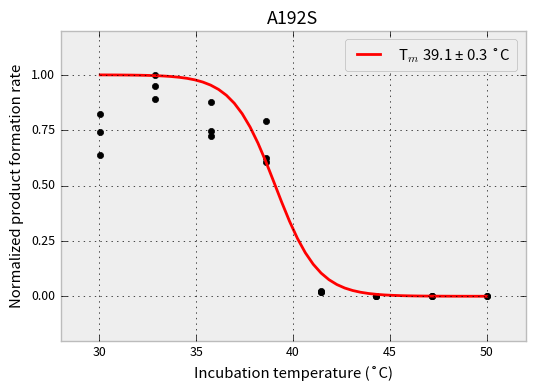

BglB


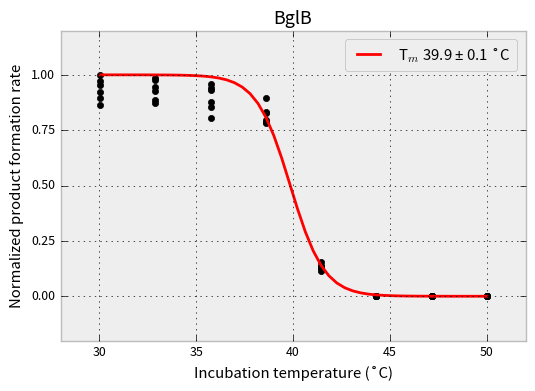

C167A


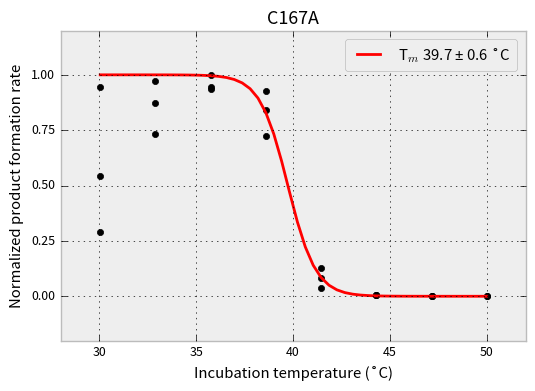

C167Q


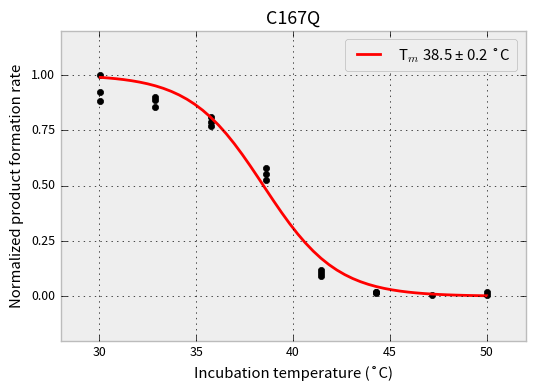

E154D


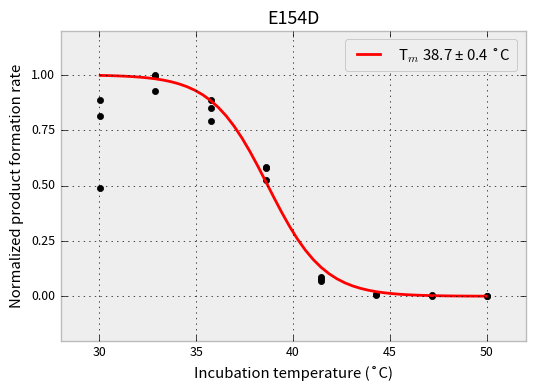

E164A


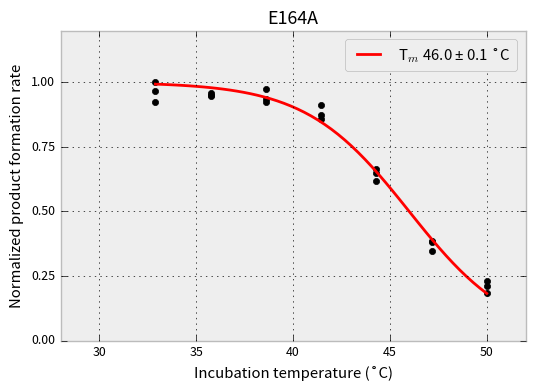

E177A


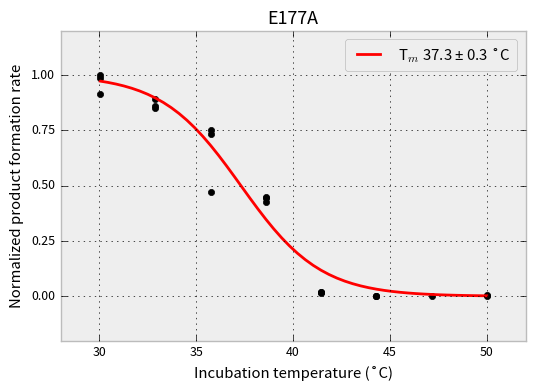

E177K


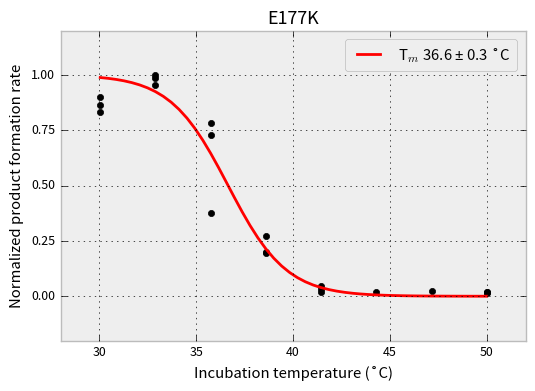

E177L


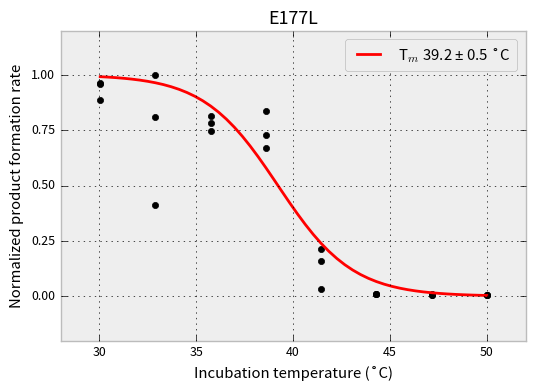

E222A


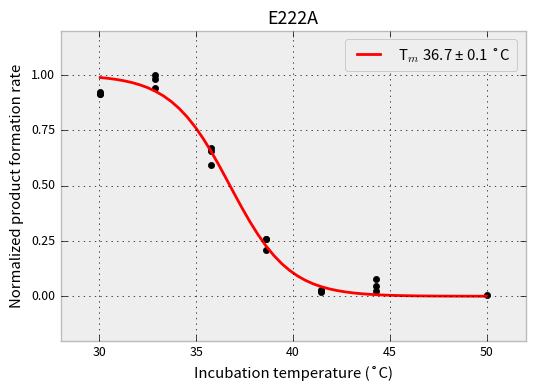

E222H


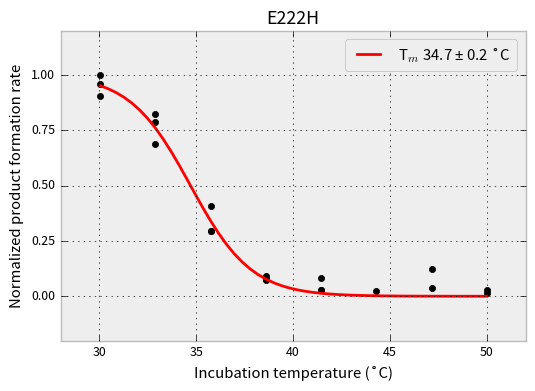

E222K


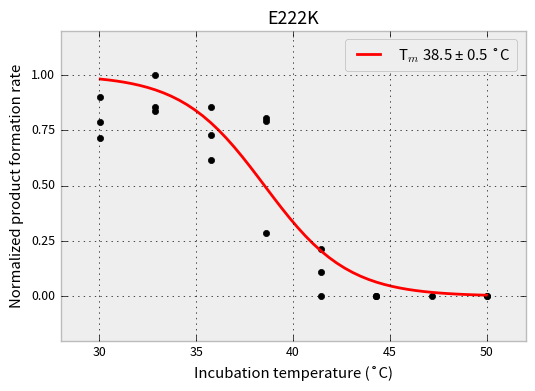

E222Q


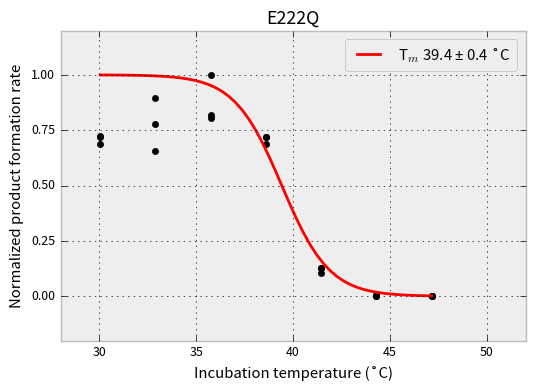

E222R


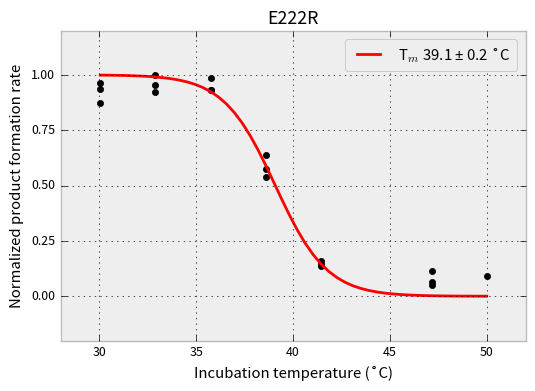

E222Y


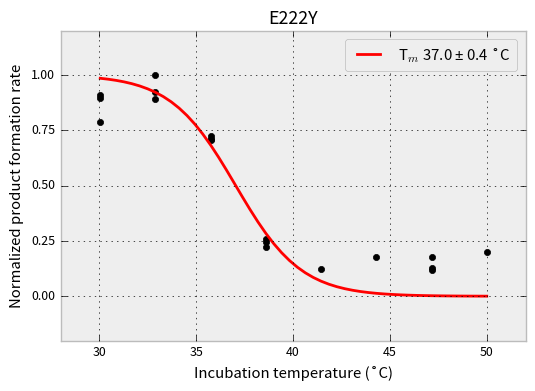

E406A


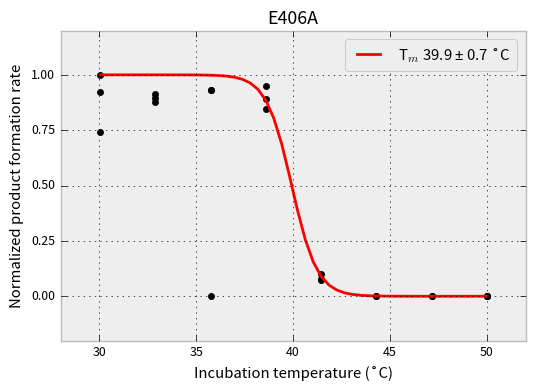

E406D


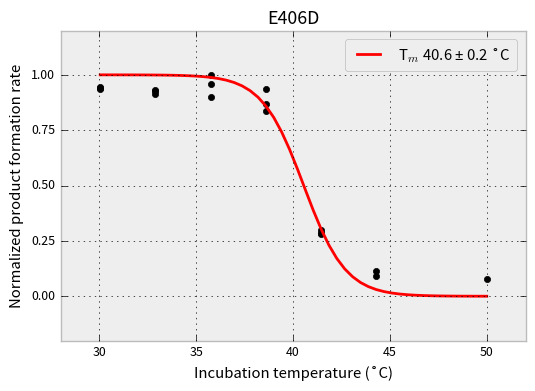

E423S


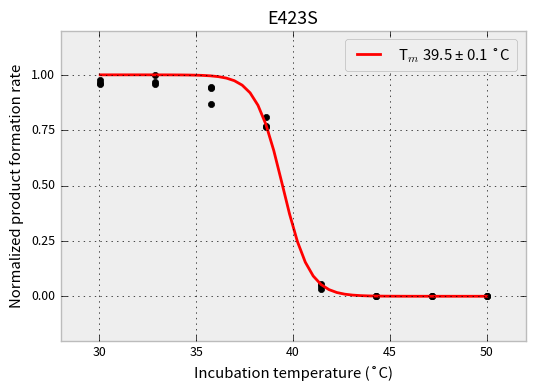

F415A


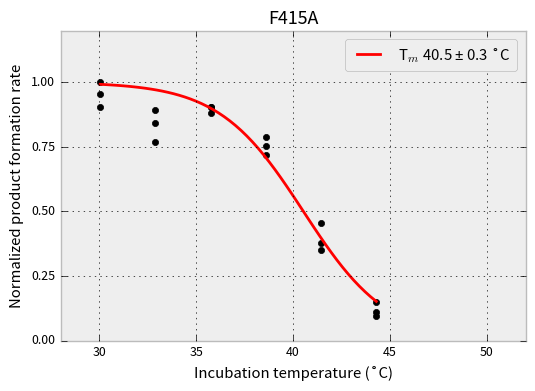

F72A


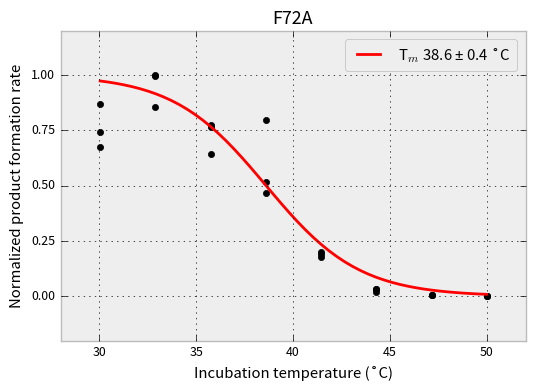

H101R


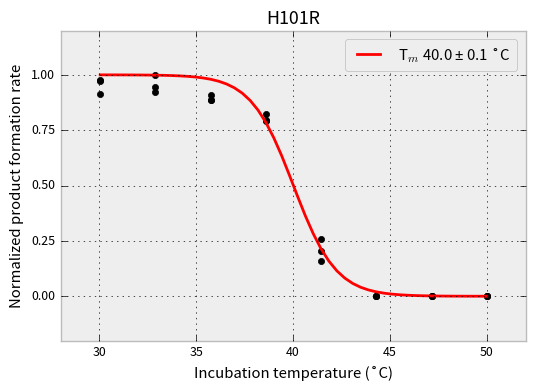

H119A


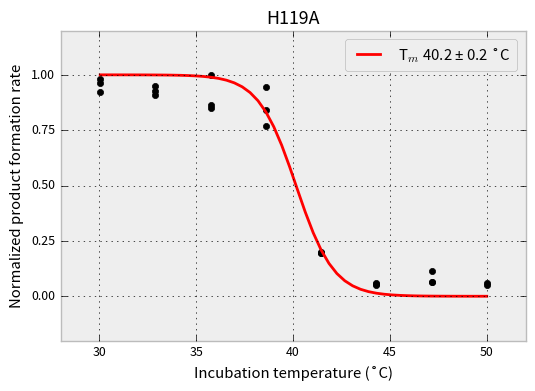

H119N


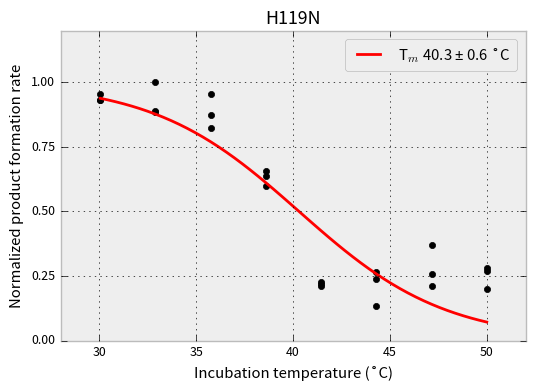

H178A


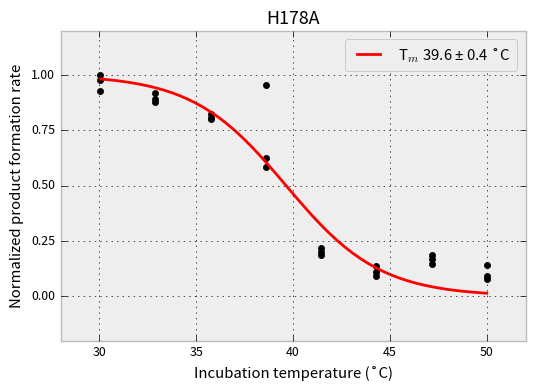

H373R


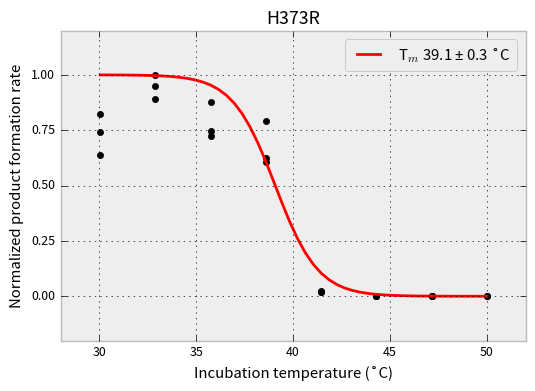

I244E


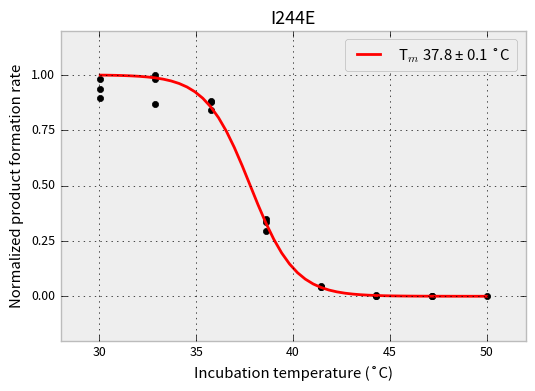

I244N


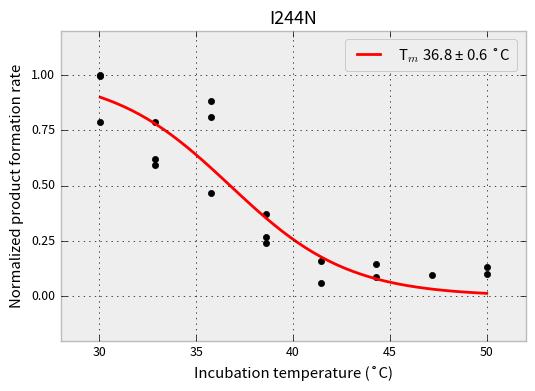

I300N


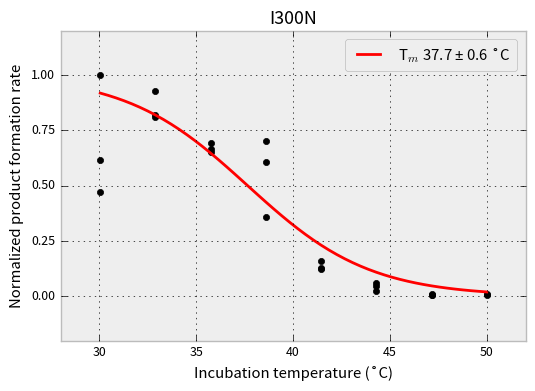

I91E


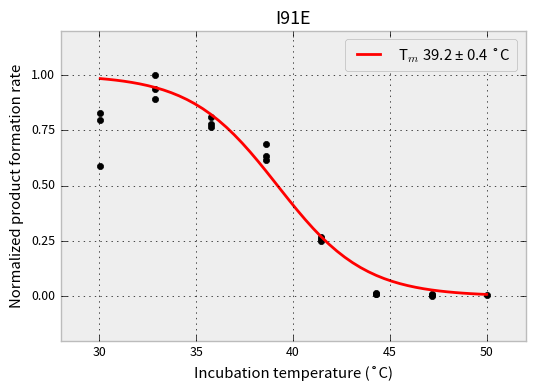

K341A


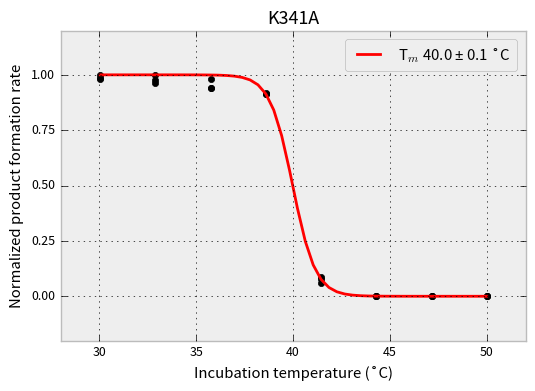

L171A


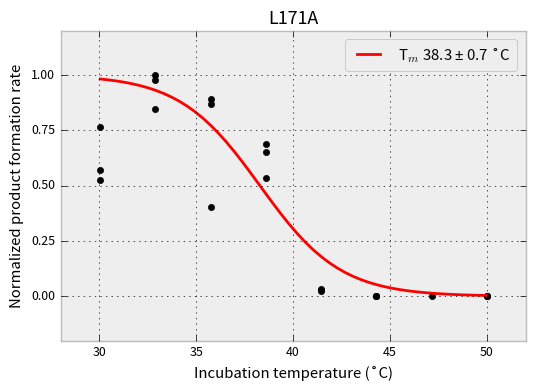

L171R


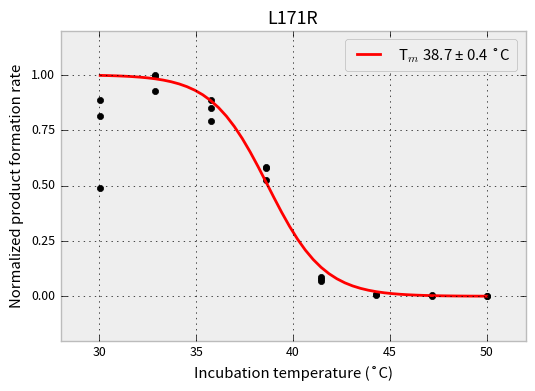

L362M


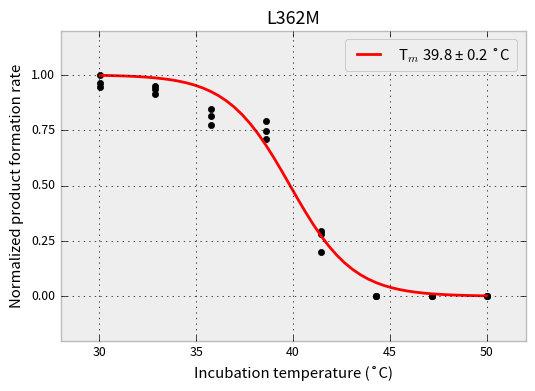

M221A


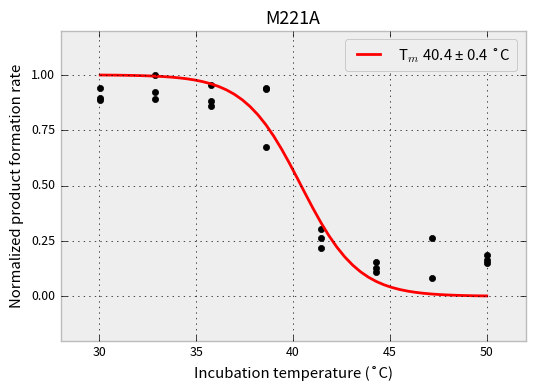

M323A


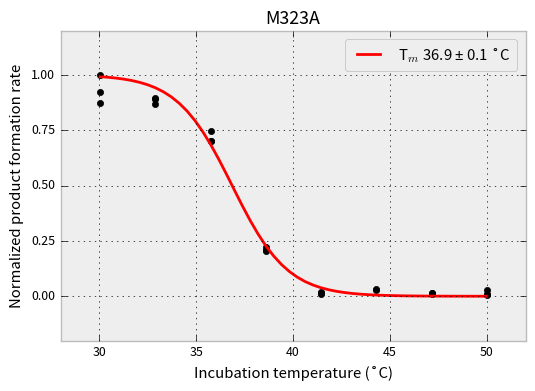

M358T


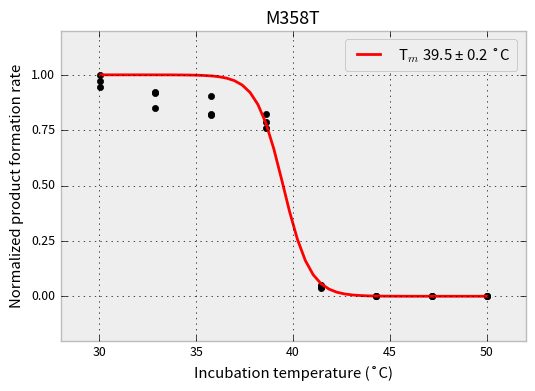

N163A


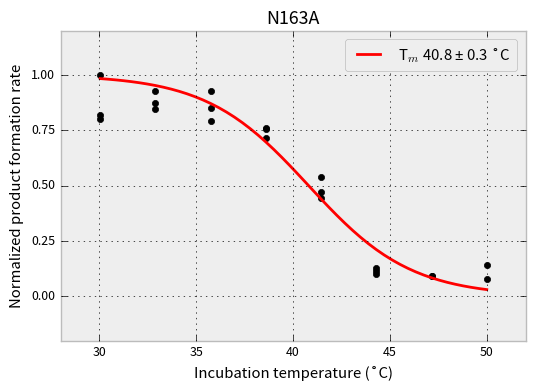

N163C


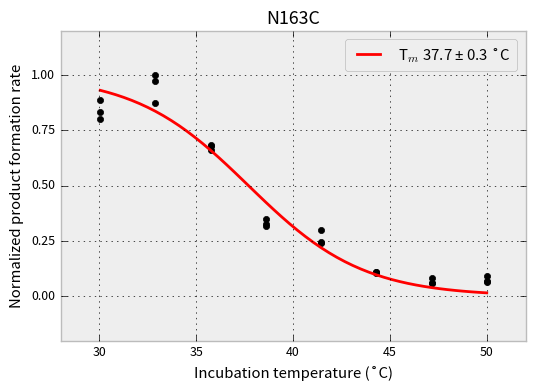

N163D


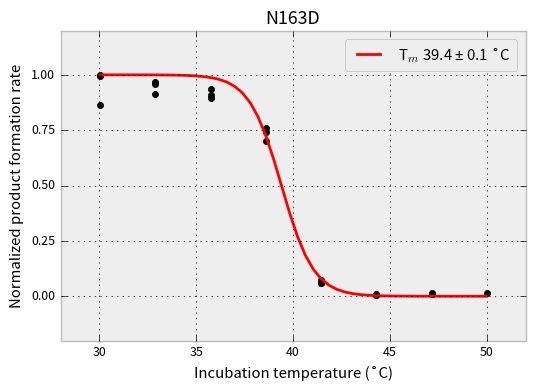

N220A


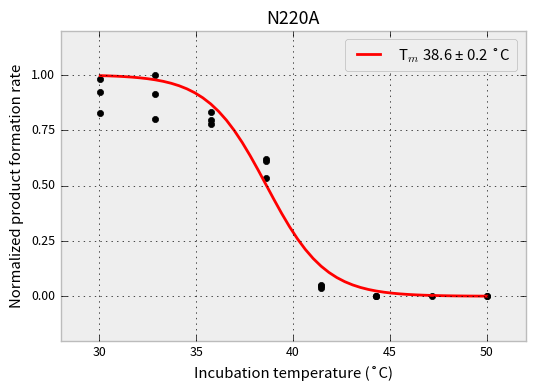

N220G


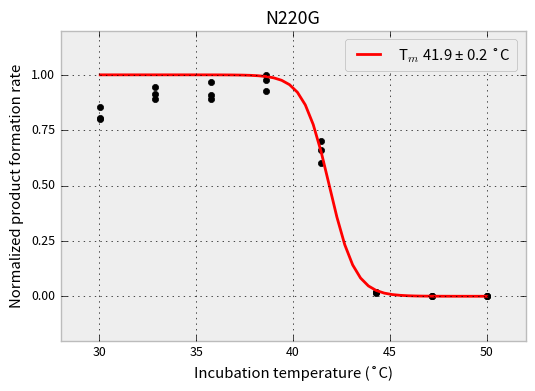

N220H


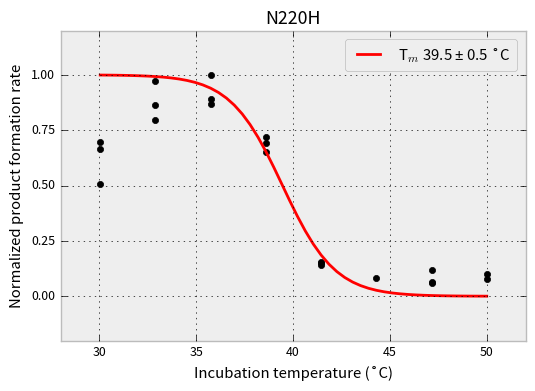

N220R


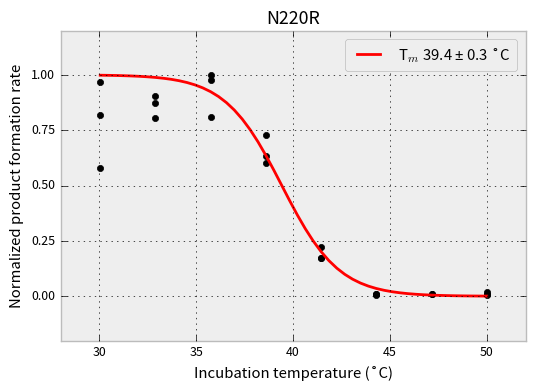

N220Y


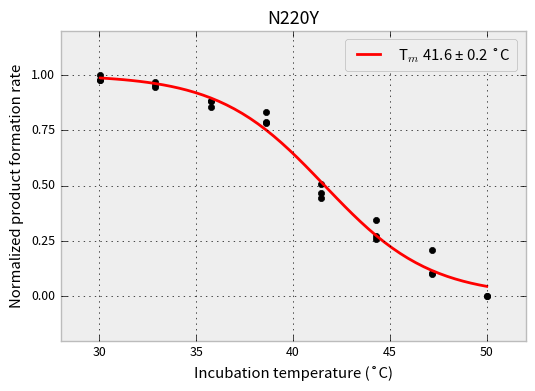

N293A


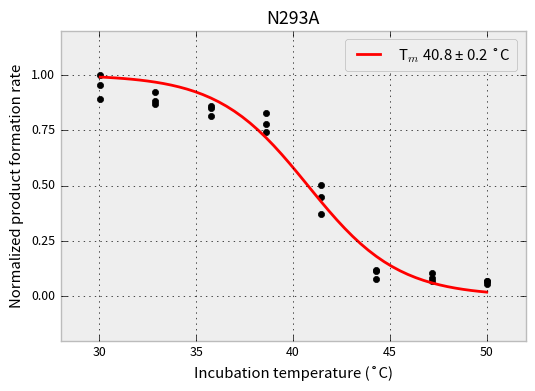

N293C


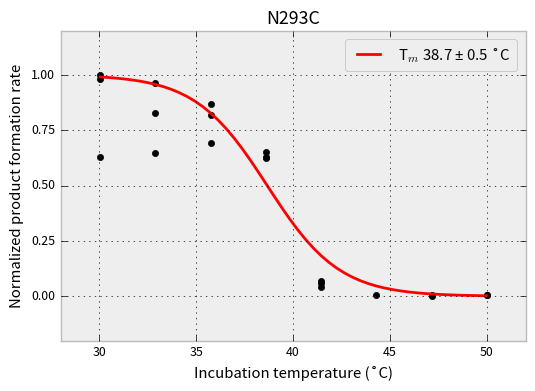

N354A


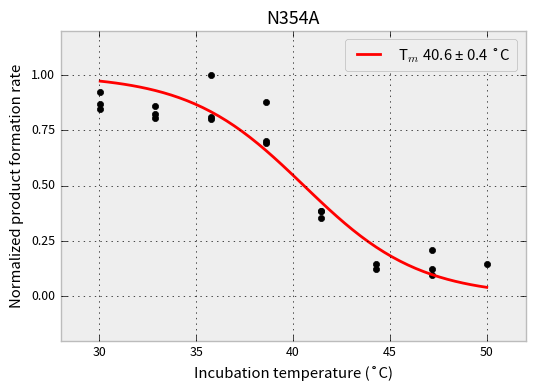

N404A


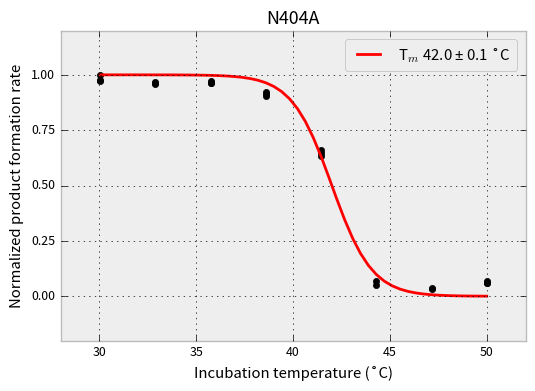

N404C


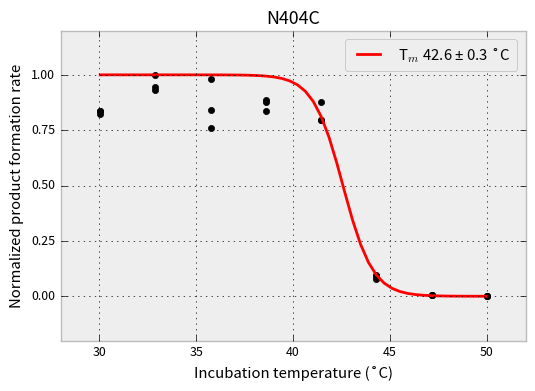

Q19S


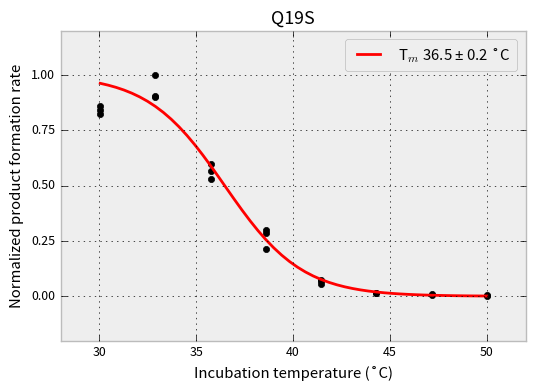

Q313R


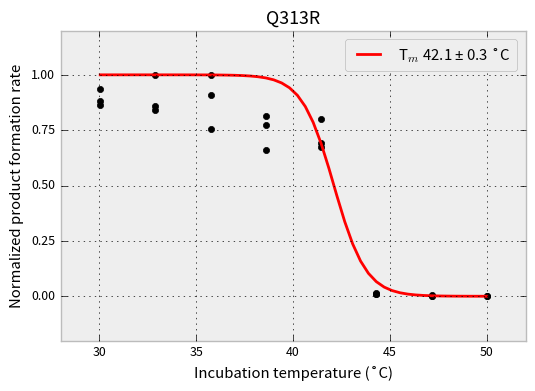

R240A


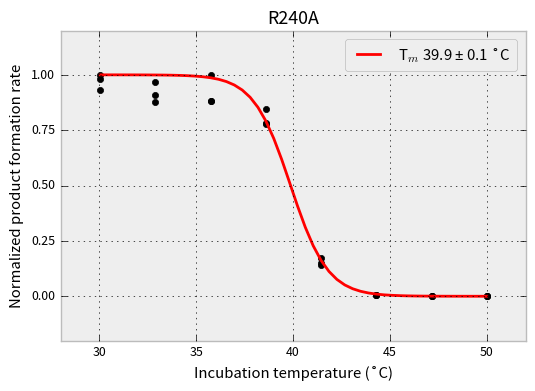

R240D


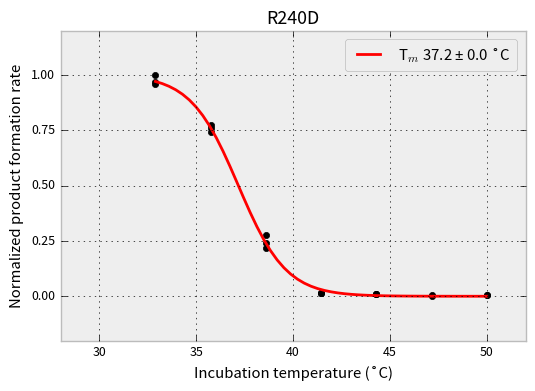

R240K


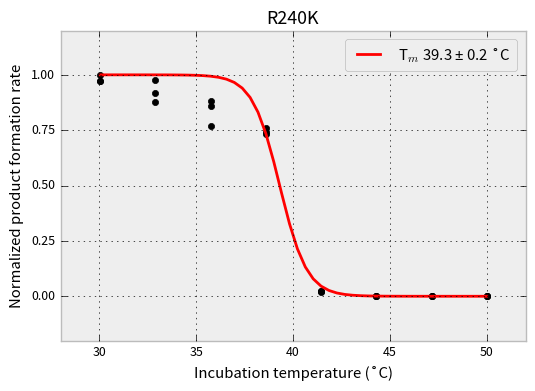

S14A


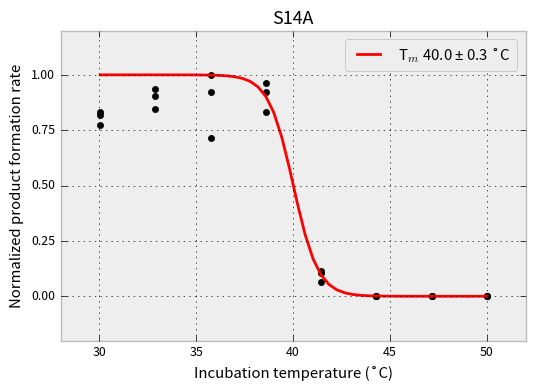

S16A


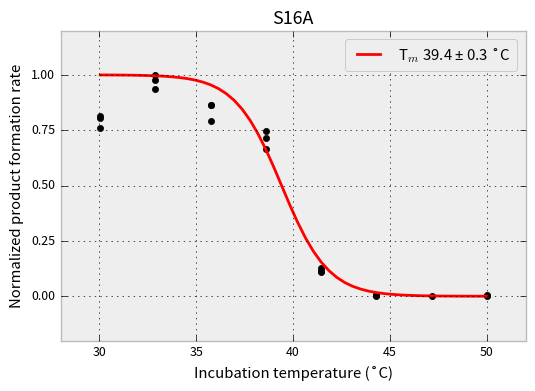

S17A


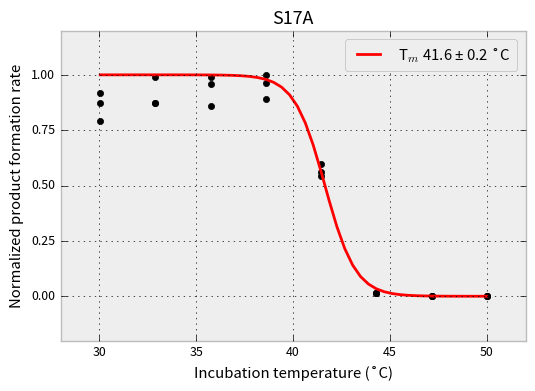

S17E


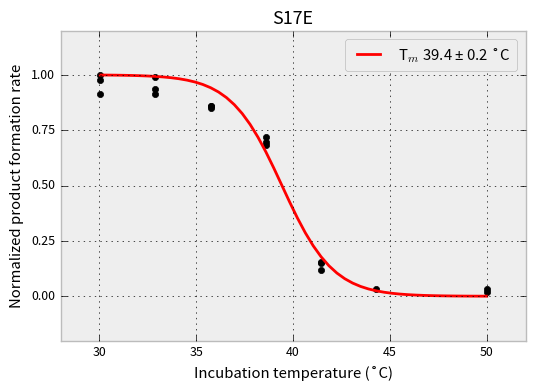

S298E


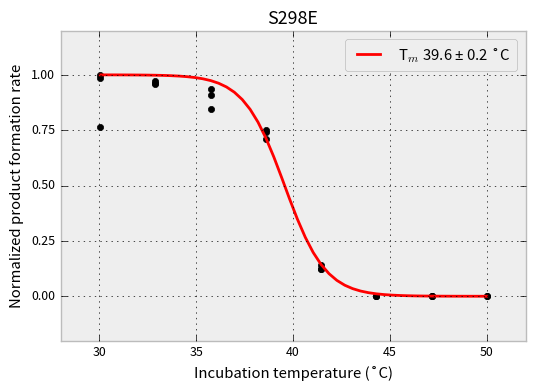

S331A


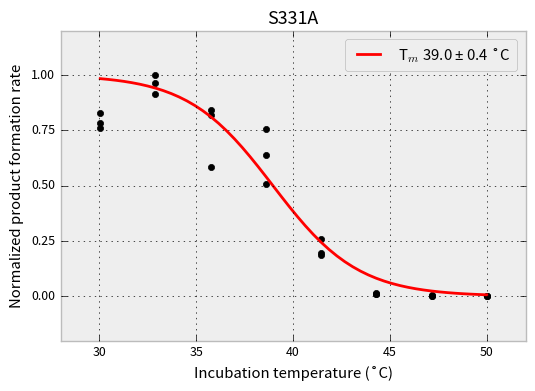

S400A


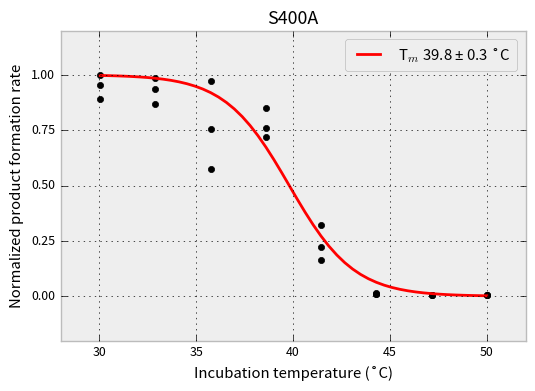

T15A


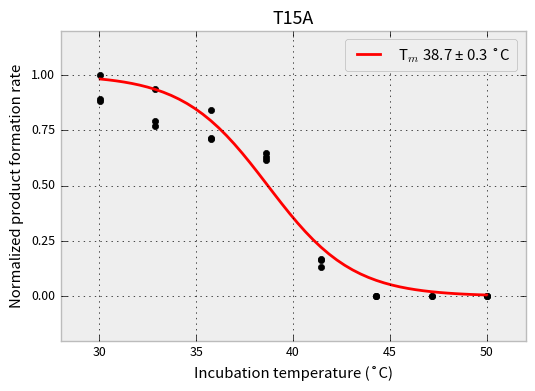

T175R


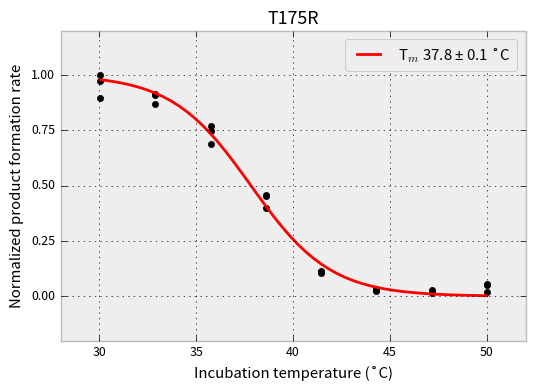

T218A


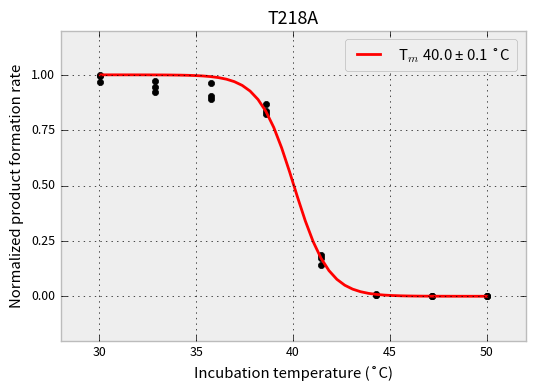

T352A


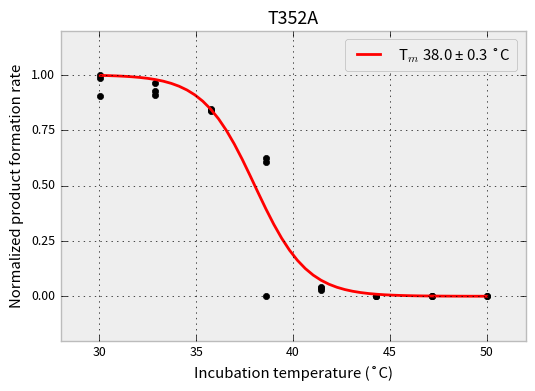

V52G


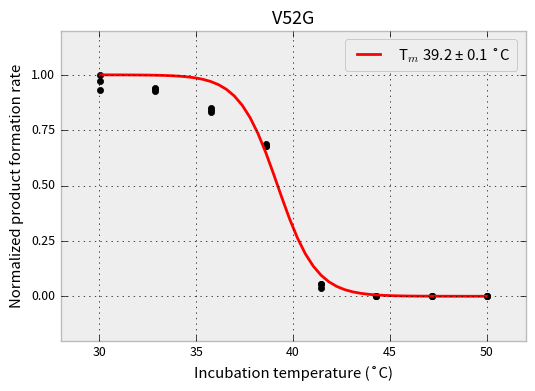

W120F


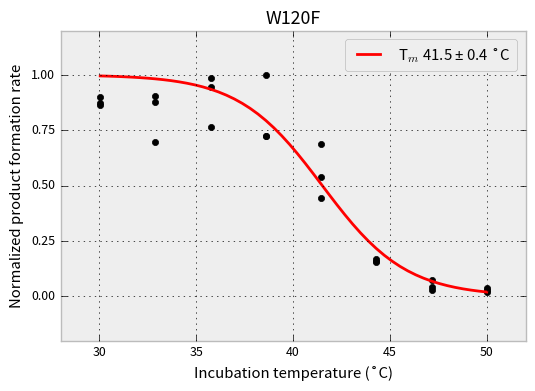

W120H


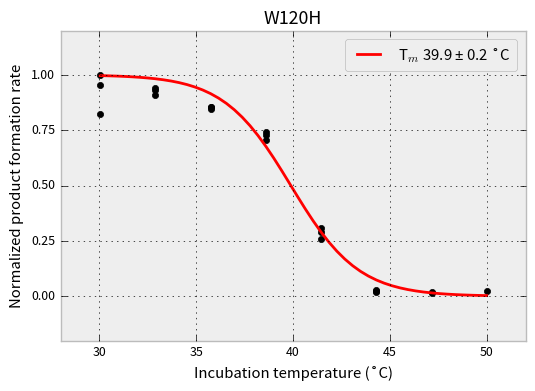

W325A


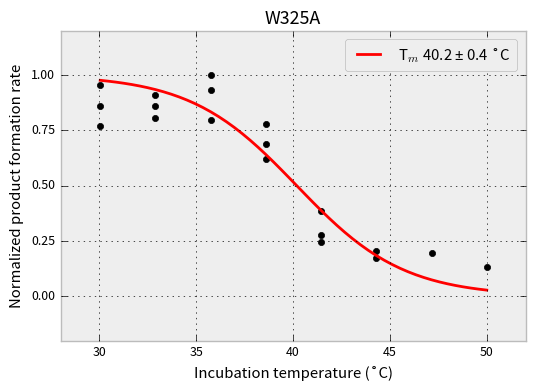

W325C


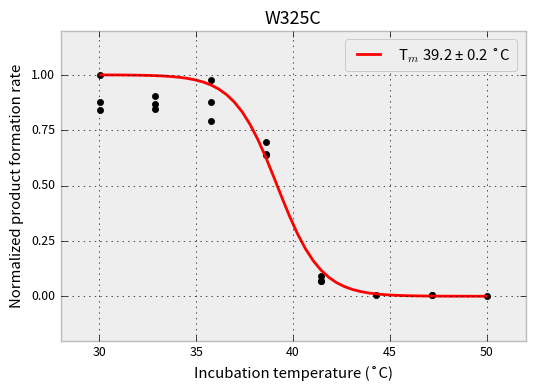

W325H


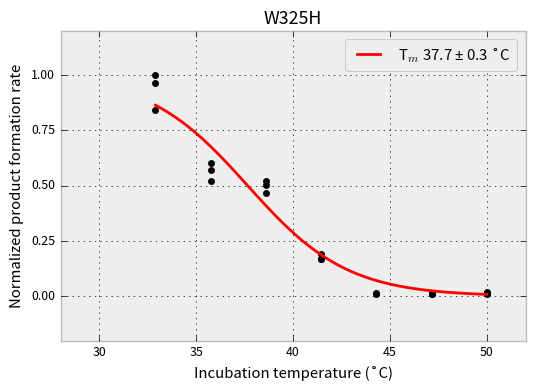

W325L


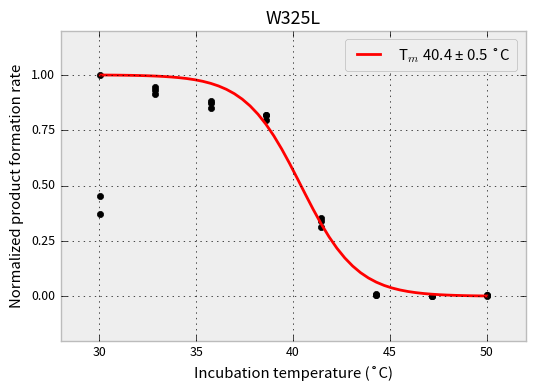

W325R


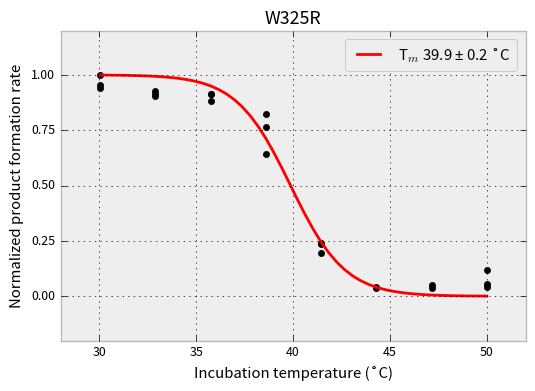

W399C


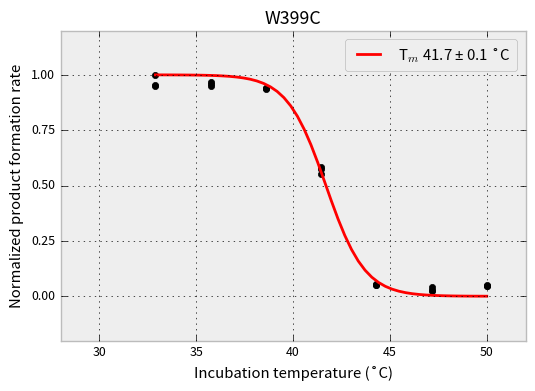

W399R


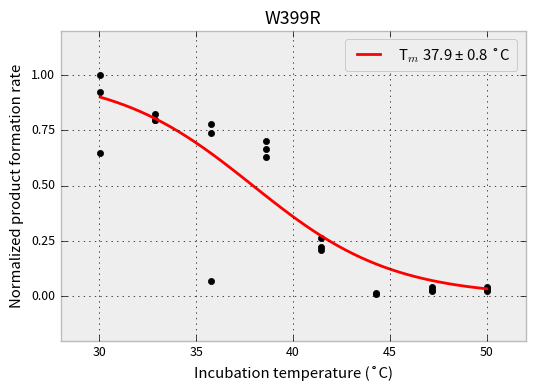

W409Y


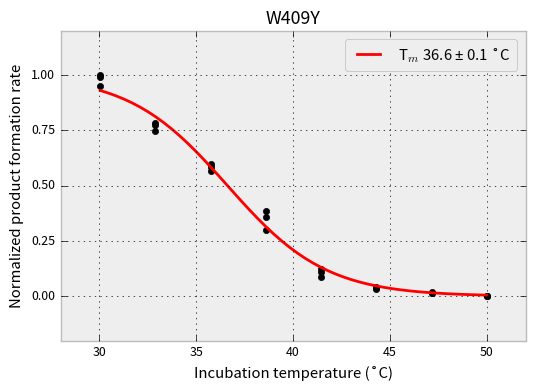

Y18A


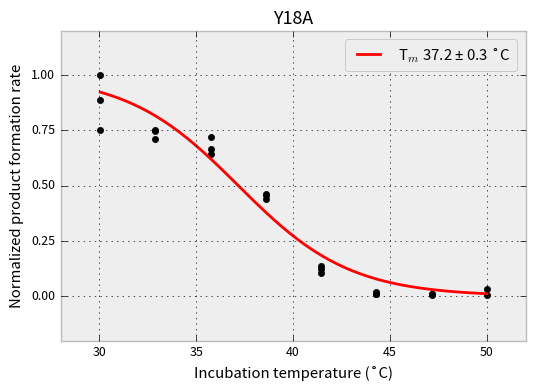

Y294A


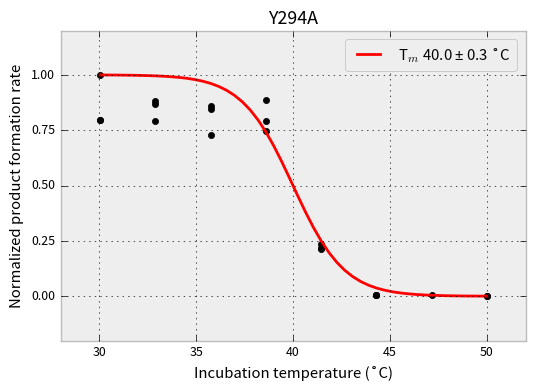

Y294F


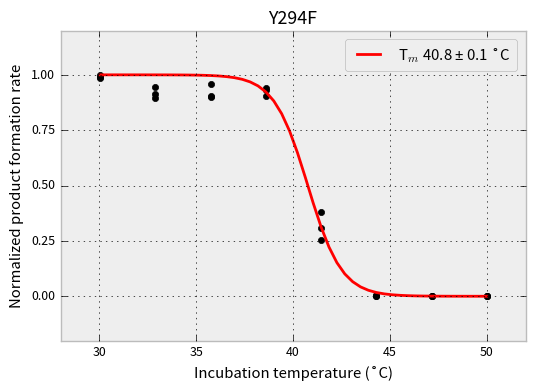

In [43]:
for idx, data in df.groupby( 'mutant' ):
    normalized_rates = data.rate / data.rate.max()
    plt.scatter( data.temp, normalized_rates, color='k' )
    x_vals = np.linspace( data.temp.min(), data.temp.max(), 50 )
    my_params = good_thermal_fits.loc[ idx ]
    plt.plot( x_vals, r( x_vals, my_params.tm, my_params.k ), color='red' )
    plt.legend( ['T$_m$ {} ± {} ˚C'.format( my_params.tm.round(1), my_params.err_tm.round(1) )], loc=1 )
    plt.xlim( ( 28, 52 ) )
    plt.xticks( ( 30, 35, 40, 45, 50 ) ) 
    plt.xlabel( 'Incubation temperature (˚C)' )
    plt.yticks( ( 0, 0.25, .5, .75, 1 ) )
    plt.ylabel( 'Normalized product formation rate' ) 
    print( idx ) 
    #plt.title( idx ) 
    if '_' in idx:
        plt.title( idx.split( '_' )[0] )
    else:
        plt.title( idx )
    plt.show()

In [46]:
master.columns

Index(['sequence_pos', 'expression', 'tm', 'k', 'err_tm', 'err_k', 'kcat',
       'err_kcat', 'km', 'err_km', 'kcatkm', 'err_kcatkm', 'ki',
       'ki_percent_err', 'ki_err', 'gel_number'],
      dtype='object')

In [56]:
# clean production data 
clean = master[ [ 'sequence_pos', 'expression', 'gel_number' ] ] 

# add in kinetics fits from above and calculate kcat/km
clean = clean.join( good_fits ) 
clean[ 'kcatkm' ] = clean[ 'kcat' ] / clean[ 'km' ] 
clean[ 'err_kcatkm' ] = np.abs(clean['kcatkm'])*np.sqrt(clean['err_kcat']/clean['kcat'])**2+(clean['err_km']/clean['km'])**2

clean = clean.join( good_thermal_fits ) 
clean.sample(5)

,sequence_pos,expression,gel_number,kcat,km,err_kcat,err_km,kcatkm,err_kcatkm,tm,k,err_tm,err_k
mutant,,,,,,,,,,,,,
N163E,163.0,0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E406D,406.0,1,15.0,NaN,NaN,NaN,NaN,NaN,NaN,40.554600,-0.926165,0.157854,0.111766
D403A,403.0,0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
W399C,399.0,1,12.0,NaN,NaN,NaN,NaN,NaN,NaN,41.700161,-0.997873,0.075438,0.087331
R240K,240.0,1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,39.314269,-1.423400,0.194697,0.327811
